# Titanic: Machine Learning from Disaster

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
import seaborn as sns
import category_encoders as ce

pd.options.display.max_colwidth = 0
pd.options.display.max_columns = 0
plt.rcParams['figure.figsize'] = 18, 6

## Importing and optimizing memory usage

I imported the data and analyzed max and min values to determine the most memory efficient typing for each column. I assigned those types using pandas `dtypes` input. Next I combined the training and test set into a single dataframe's for ease of analysis. I also set the passenger ID column as a the dataframe index.

In [2]:
train_types = {
    'Age': np.float32,
    'Cabin': str,
    'Embarked': str,
    'Fare': np.float32,
    'Name': str,
    'Parch': np.int8,
    'Pclass': np.int8,
    'Sex': str,
    'SibSp': np.int8,
    'Survived': np.int8,
    'Ticket': str
}

train = pd.read_csv('data/train.csv', index_col='PassengerId', dtype=train_types)
test = pd.read_csv('data/test.csv', index_col='PassengerId', dtype=train_types)
full = pd.concat([train, test])
full.columns = full.columns.str.lower()
full.index.rename('pid', inplace=True)
full.head()

,age,cabin,embarked,fare,name,parch,pclass,sex,sibsp,survived,ticket
pid,,,,,,,,,,,
1,22.0,NaN,S,7.250000,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171
2,38.0,C85,C,71.283302,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",0,1,female,1,1.0,PC 17599
3,26.0,NaN,S,7.925000,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282
4,35.0,C123,S,53.099998,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803
5,35.0,NaN,S,8.050000,"Allen, Mr. William Henry",0,3,male,0,0.0,373450


## Checking for null values

Age and cabin are the main offenders, with a majority of cabin values missing. I dealt with these missing values later, in the **Feature Engineering** section. The null values in `survived` represent the values from the test set (to be predicted).

In [3]:
len(full)

1309

In [4]:
full.isnull().sum()

age         263 
cabin       1014
embarked    2   
fare        1   
name        0   
parch       0   
pclass      0   
sex         0   
sibsp       0   
survived    418 
ticket      0   
dtype: int64

I manually inspected the null values in `embarked` and `fare` and replaced them with the most likely values given other data for that passenger (namely `pclass` and `fare` or `embarked`).

In [5]:
full['embarked'].fillna('S', inplace=True)
full['fare'].fillna(8.05, inplace=True)

## Feature engineering
_Note: For brevity, I opted to exclude my exploratory data analysis, which was performed before feature engineering._

**Adding `title` feature**

First, I mapped the `sex` categorical variable to a binary column. I extracted the title (Mr., Mrs., etc.) from the name field, condensing one-off titles into a catch-all category called 'Other'.

In [6]:
full['gender'] = full['sex'].map({'male':1, 'female':0})
full[['surname','title']] = full.name.str.extract('(\w+), (.*?)\..*', expand=True)
full['title'] = full['title'].replace('Ms', 'Miss')
to_replace = list(set(full['title'].tolist()).difference(['Mr', 'Miss', 'Mrs', 'Master']))
full['title'] = full['title'].replace(to_replace, 'Other')

**Creating `deck`, `even_cabin` and `cabin_num` features from `cabin`**

On the Titanic, odd and even cabins were on opposite sides of the ship, while the letter of the cabin represented the deck, or vertical position. I thought these would likely be important features to include, so I created a binary feature called `even_cabin`, extracted the first letter of each cabin as `deck`, filling the missing values with `X`, and included the cabin number for good measure.

In [7]:
full['deck'] = full['cabin'].str.extract('([A-Z]).*',expand=True)
full['deck'].fillna('X', inplace=True)
full['even_cabin'] = full['cabin'].str.extract('[A-Z]([0-9]+)', expand=True).fillna(0).astype(int) % 2
full['cabin_num'] = full['cabin'].str.extract('[A-Z]([0-9]+)', expand=True).fillna(0).astype(int)

**Imputing `age` by `title`**

To determine the missing age values, I calculated the median age by title and used that value to fill the missing ages.

In [8]:
median_age = full.groupby('title')['age'].median().to_dict()
full.loc[full['age'].isnull(), 'age'] = full.loc[full['age'].isnull(), 'title'].map(median_age)

**Creating adjusted fare column**

I realized that there were a lot of outliers in the fare feature. Upon further inspection, it seemed that the total fare included multiple passengers, and represented the fare for that _ticket_ not that passenger. I created a feature called `npass` to represent the number of passengers on each ticket, and used that to adjust the total fare by passenger.

In [9]:
full['npass'] = full.groupby('ticket')['ticket'].transform('count')
full['fare_adj'] = full['fare'] / full['npass']

**Creating family features (`child`, `famsize` and `alone`)**

I created a number of features related to the family traveling with each passenger. `sibsp` and `parch` represent the number of siblings or spouses and/or parents or children traveling and can be summed to represent the number of family members. I've added one to represent the passenger.

I also added a feature to represent passengers traveling alone and to represent children (under age 18).

In [10]:
full['famsize'] = full['sibsp'] + full['parch'] + 1
full.loc[:, 'child'] = 0
full.loc[full['age'] < 18, 'child'] = 1
full['alone'] = 0
full.loc[full['famsize'] == 1, 'alone'] = 1
full.head()

,age,cabin,embarked,fare,name,parch,pclass,sex,sibsp,survived,ticket,gender,surname,title,deck,even_cabin,cabin_num,npass,fare_adj,famsize,child,alone
pid,,,,,,,,,,,,,,,,,,,,,,
1,22.0,NaN,S,7.250000,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171,1,Braund,Mr,X,0,0,1,7.250000,2,0,0
2,38.0,C85,C,71.283302,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",0,1,female,1,1.0,PC 17599,0,Cumings,Mrs,C,1,85,2,35.641651,2,0,0
3,26.0,NaN,S,7.925000,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282,0,Heikkinen,Miss,X,0,0,1,7.925000,1,0,1
4,35.0,C123,S,53.099998,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803,0,Futrelle,Mrs,C,1,123,2,26.549999,2,0,0
5,35.0,NaN,S,8.050000,"Allen, Mr. William Henry",0,3,male,0,0.0,373450,1,Allen,Mr,X,0,0,1,8.050000,1,0,1


**Examine feature correlation heatmap**

Looking at `survived`, our predictor variable, there is a strong correlation with `gender`, `pclass`, `fare_adj`, and `even_cabin`. These features make intuitive sense. Women and children were the first in the lifeboats, passengers with higher status or income were likely given priority, and being in a cabin on the impacted side of the Titanic likely affected survival.

`fare` and `pclass` are highly correlated, which is to be expected. Alone is highly correlated with the family features. Removing some of these family features may help with the dimensionality of the model.

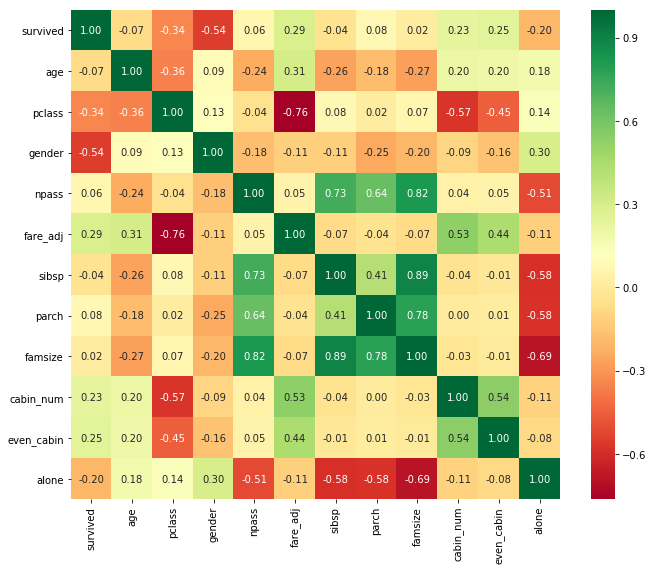

In [11]:
f, ax = plt.subplots(figsize=[11,9])
train = full[~full['survived'].isnull()]
sns.heatmap(
    train[['survived', 'age', 'pclass', 'gender', 'npass', 'fare_adj',
           'sibsp', 'parch', 'famsize', 'cabin_num', 'even_cabin',
           'alone']].corr(),
    annot=True,
    cmap='RdYlGn',
    fmt='.2f',
    square=True
)
plt.show()

## Prepare data for training

**Encode categorical variables using a binary encoder and re-create test and training sets**

After some testing, I opted to use a binary encoder instead of one-hot encoding for my categorical variables. It performed slightly better and reduces dimensionality.

In [12]:
encoded = full.drop(['fare', 'cabin', 'name', 'surname', 'ticket', 'sex', 'sibsp', 'parch'], axis=1)
encoder = ce.BinaryEncoder()
y = encoded['survived']
X = encoded.drop('survived', axis=1)
encoder.fit(X, y)
X_encoded = encoder.transform(X)
X_train = X_encoded[~y.isnull()]
y_train = y[~y.isnull()]
X_test = X_encoded[y.isnull()]
X_train.head()

,embarked_0,embarked_1,title_0,title_1,title_2,deck_0,deck_1,deck_2,deck_3,age,pclass,gender,even_cabin,cabin_num,npass,fare_adj,famsize,child,alone
pid,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,22.0,3,1,0,0,1,7.250000,2,0,0
2,0,1,0,0,1,0,0,0,1,38.0,1,0,1,85,2,35.641651,2,0,0
3,0,0,0,1,0,0,0,0,0,26.0,3,0,0,0,1,7.925000,1,0,1
4,0,0,0,0,1,0,0,0,1,35.0,1,0,1,123,2,26.549999,2,0,0
5,0,0,0,0,0,0,0,0,0,35.0,3,1,0,0,1,8.050000,1,0,1


## Train Random Forest classifier

I opted for a random forest model because it generally performs well for classification problems and is straightforward to implement. I also created a parameter tuning grid to test different combinations of hyperparameters.

In [13]:
seed = 11
parameter_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [2, 5, 8],
    'n_estimators': [50, 10],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
}
clf = ExtraTreesClassifier(n_jobs=2, random_state=seed)

grid_search = GridSearchCV(
    clf,
    scoring='accuracy',
    param_grid=parameter_grid,
    cv=3,
    n_jobs=2,
    verbose=1
)

grid_search.fit(X_train, y_train)
clf = grid_search.best_estimator_
parameters = grid_search.best_params_

print('Best score: {:.2f}'.format(grid_search.best_score_))
print('Best estimator: {}'.format(grid_search.best_estimator_))

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    7.9s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   33.7s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.3min


Best score: 0.83
Best estimator: ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=5, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
           oob_score=False, random_state=11, verbose=0, warm_start=False)


[Parallel(n_jobs=2)]: Done 648 out of 648 | elapsed:  1.8min finished


**Examining feature importance**

Looking at the top five features, we see that `gender` is by far the most significant. `title_2` and `title_1` closely represent `Mr.` and `Mrs.` and are likely highly correlated with `gender`. Next up is `pclass`, which affected the passenger's location on the ship and priority in reaching the lifeboats.

In [14]:
features = list(zip(X_train.columns, np.transpose(clf.feature_importances_ * 100)))
features = pd.DataFrame(features, columns=['feature','importance']).sort_values('importance', ascending=False)
features['importance'] = features['importance'].astype(int)
features.head(10)

,feature,importance
11,gender,29
4,title_2,15
3,title_1,13
10,pclass,10
7,deck_2,5
12,even_cabin,3
16,famsize,3
15,fare_adj,3
14,npass,2
6,deck_1,2


## Predict and Export results to CSV

Finally, I predicted the survival of the passengers in the test set. Using the approach above, I scored in the top 25% of participants in this Kaggle contest.

In [15]:
result = pd.DataFrame({'PassengerId': X_test.index.tolist()})
result['Survived'] = clf.predict(X_test).astype(int)
result.to_csv('submissions/submission.csv', index=False)